In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from preprocess import remove_duplicates
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from utils.plot_config import format_plot, set_plot_style

In [4]:

train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
duplicates_df = pd.read_csv('data/2020_challenge_duplicates.csv')


remove_duplicates(train_data, test_data, duplicates_df)
    
train_data = train_data.dropna()
test_data = test_data.dropna()


patient_id
IP_7279968    115
IP_4479736    115
IP_4382720    115
IP_0656529    114
IP_4938382    114
             ... 
IP_0951529      3
IP_3645134      3
IP_9053722      2
IP_8335299      2
IP_4615697      2
Name: count, Length: 2051, dtype: int64


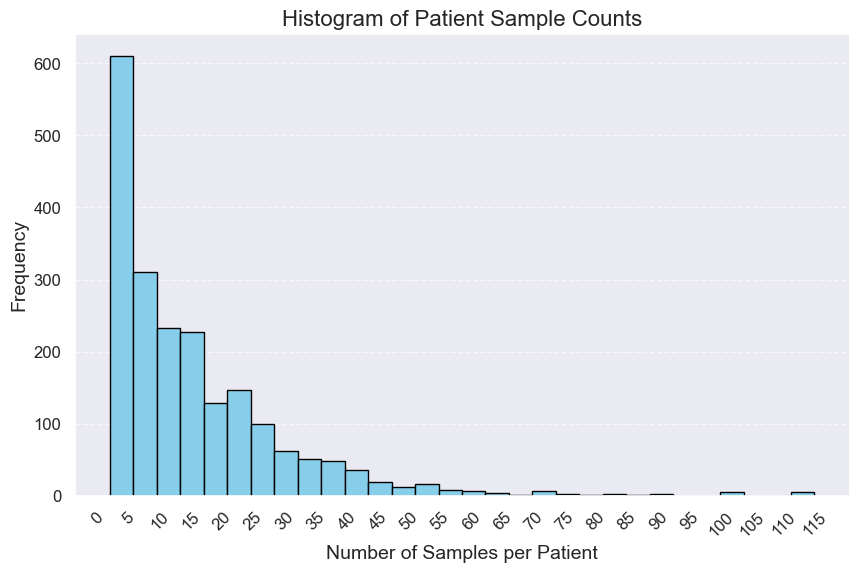

In [45]:
patient_sample_counts = train_data['patient_id'].value_counts()
print(patient_sample_counts)

plt.figure(figsize=(10, 6))
patient_sample_counts.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Patient Sample Counts')
plt.xlabel('Number of Samples per Patient')
plt.ylabel('Frequency')

# Increase the number of ticks on the x-axis
plt.xticks(ticks=range(0, int(patient_sample_counts.max()) + 1, 5), rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
# Count samples per patient
patient_sample_counts = train_data['patient_id'].value_counts().reset_index()
patient_sample_counts.columns = ['patient_id', 'sample_count']

# Sort patients by their sample count (ascending)
patient_sample_counts = patient_sample_counts.sort_values('sample_count')

duplicated_data = train_data.sort_values(['patient_id'])

# Get all positive samples
positive_samples = train_data[train_data['target'] == 1]

# Remove positive samples from duplicated data
duplicated_data = duplicated_data[~duplicated_data['image_name'].isin(positive_samples['image_name'])]

# Group by patient_id and sample two rows per patient
sampled_data = duplicated_data.groupby('patient_id').apply(lambda x: x.sample(n=2, replace=True)).reset_index(drop=True)

combined_data = pd.concat([positive_samples, sampled_data], ignore_index=True)

# Count the number of images for each unique patient_id
patient_image_counts = combined_data['patient_id'].value_counts()

# Display the counts
print(patient_image_counts)



patient_id
IP_7373371    10
IP_9111321     8
IP_2412574     7
IP_3237442     7
IP_5399626     6
              ..
IP_3359673     2
IP_3358218     2
IP_3350187     2
IP_3349523     2
IP_9996429     2
Name: count, Length: 2051, dtype: int64


C:\Users\phili\AppData\Local\Temp\ipykernel_53620\2358543423.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = duplicated_data.groupby('patient_id').apply(lambda x: x.sample(n=2, replace=True)).reset_index(drop=True)


In [ ]:
train_data = combined_data

    
# Stratified sampling based on target (melanoma) while respecting patient IDs

# Group by patient_id and get the target value for each patient
# We'll use the most common target value per patient
patient_targets = train_data.groupby('patient_id')['target'].mean().reset_index()
# If a patient has any positive samples, we'll consider them positive (mean > 0)
patient_targets['target_binary'] = (patient_targets['target'] > 0).astype(int)

# Split patients, not individual samples, stratifying by target
train_patients, val_patients = train_test_split(
    patient_targets['patient_id'],
    test_size=300,
    stratify=patient_targets['target_binary'],
    random_state=42
)

# Split the data based on patient assignment
val_data = train_data[train_data['patient_id'].isin(val_patients)]
train_data = train_data[train_data['patient_id'].isin(train_patients)]

print(len(train_data))
print(len(val_data))

3987
685


In [111]:
val_data[val_data['target'] == 1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
1,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
12,ISIC_0327406,IP_7069391,male,40.0,upper extremity,melanoma,malignant,1
22,ISIC_0559335,IP_6067392,male,60.0,torso,melanoma,malignant,1
28,ISIC_0647224,IP_5064161,male,30.0,lower extremity,melanoma,malignant,1
31,ISIC_0779920,IP_9663529,female,75.0,upper extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
557,ISIC_9677503,IP_5086592,male,55.0,head/neck,melanoma,malignant,1
562,ISIC_9821002,IP_5063756,male,75.0,lower extremity,melanoma,malignant,1
567,ISIC_9910791,IP_6776978,female,60.0,head/neck,melanoma,malignant,1
568,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1


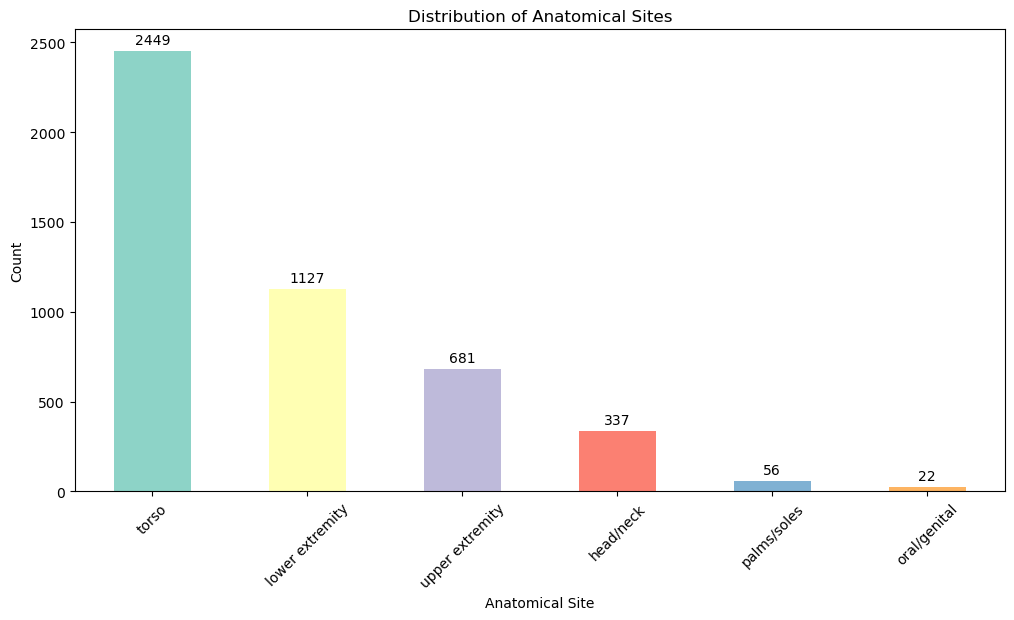

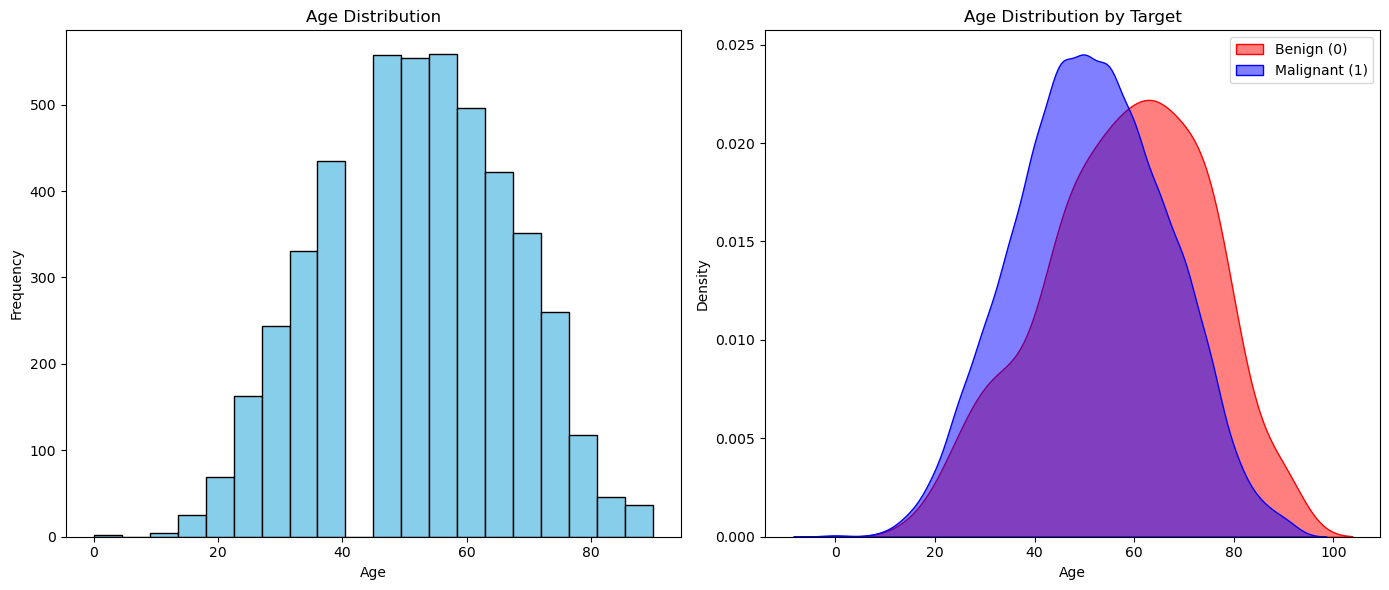

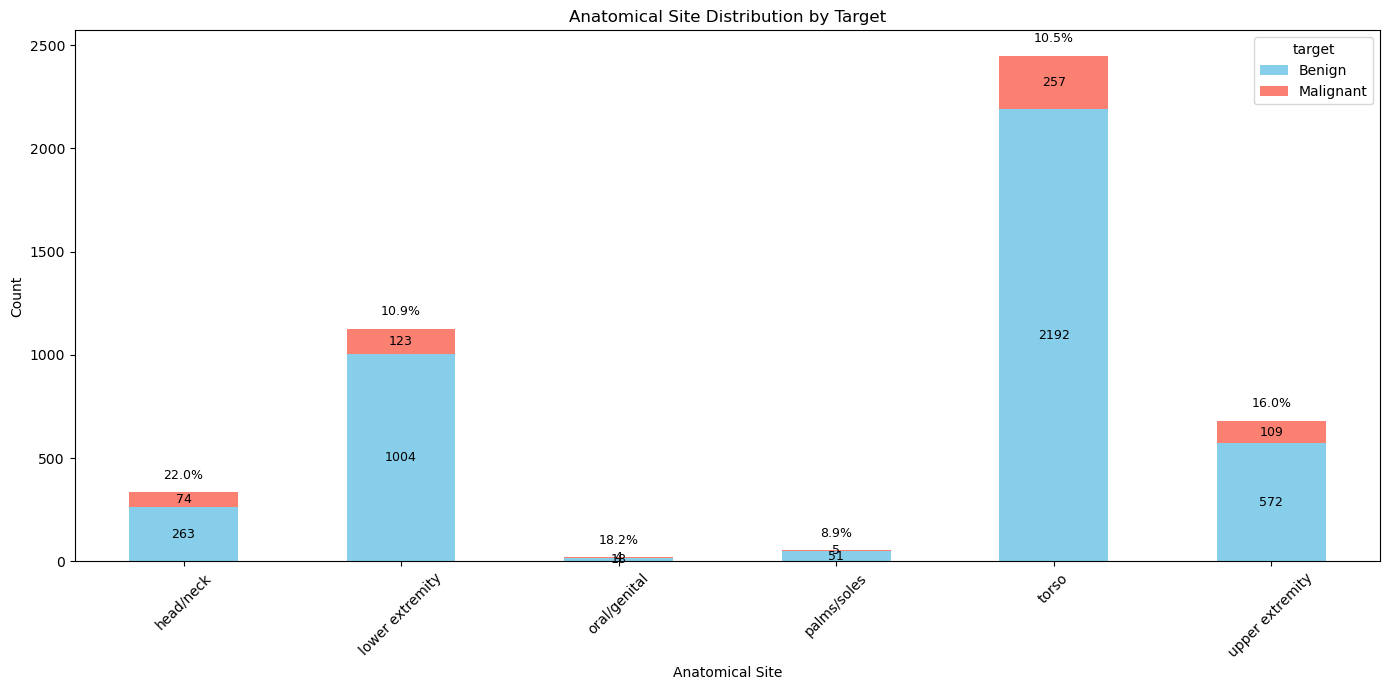

In [55]:
# Plot anatomical site distribution
site_counts = combined_data['anatom_site_general_challenge'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
bars = site_counts.plot(kind='bar', ax=ax, color=plt.cm.Set3.colors)
ax.set_title('Distribution of Anatomical Sites')
ax.set_xlabel('Anatomical Site')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Annotate bars with values
for bar in bars.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', size=10, xytext=(0, 8),
                textcoords='offset points')

# Age distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
combined_data['age_approx'].plot(kind='hist', bins=20, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')

# Age distribution by target
sns.kdeplot(data=combined_data, x='age_approx', hue='target', 
            fill=True, common_norm=False, alpha=0.5, ax=ax2,
            palette={0: 'blue', 1: 'red'})
ax2.set_title('Age Distribution by Target')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.legend(['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# Create a figure for anatomical site distribution by target
fig, ax = plt.subplots(figsize=(14, 7))

# Cross-tabulation of anatomical site and target
site_target = pd.crosstab(combined_data['anatom_site_general_challenge'], combined_data['target'])
site_target.rename(columns={0: 'Benign', 1: 'Malignant'}, inplace=True)

# Plot stacked bar chart
site_target.plot(kind='bar', stacked=True, ax=ax, 
                 color=['skyblue', 'salmon'])
ax.set_title('Anatomical Site Distribution by Target')
ax.set_xlabel('Anatomical Site')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Add value annotations
for i, (benign, malignant) in enumerate(zip(site_target['Benign'], site_target['Malignant'])):
    total = benign + malignant
    ax.annotate(f'{benign}', 
                xy=(i, benign/2), 
                ha='center', va='center', 
                color='black',
                fontsize=9)
    ax.annotate(f'{malignant}', 
                xy=(i, benign + malignant/2), 
                ha='center', va='center', 
                color='black', 
                fontsize=9)
    # Show percentage of malignant
    if total > 0:
        percent_malignant = (malignant / total) * 100
        ax.annotate(f'{percent_malignant:.1f}%', 
                    xy=(i, total + 50), 
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

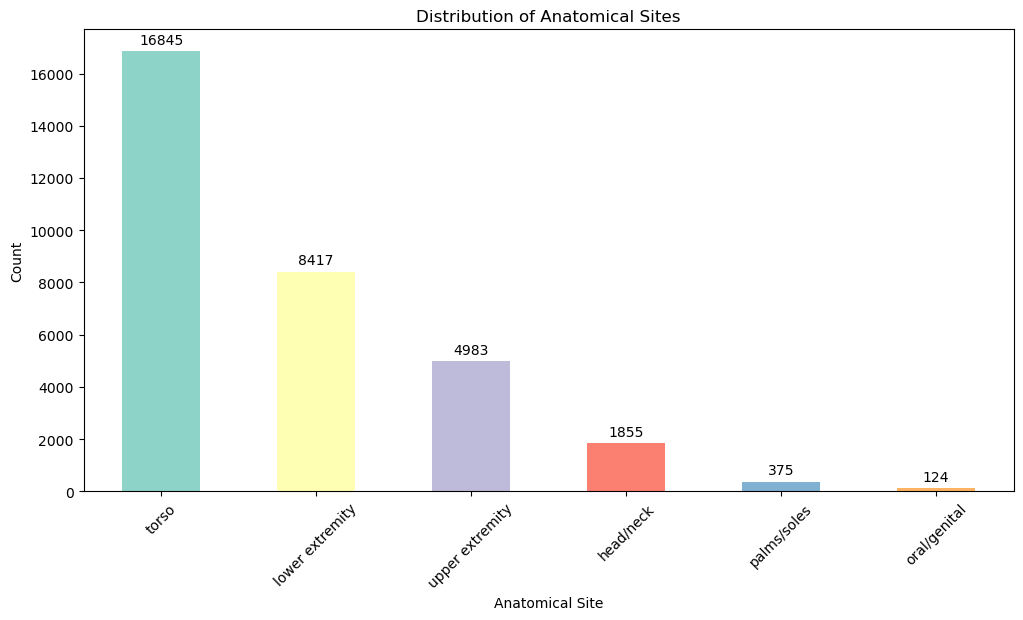

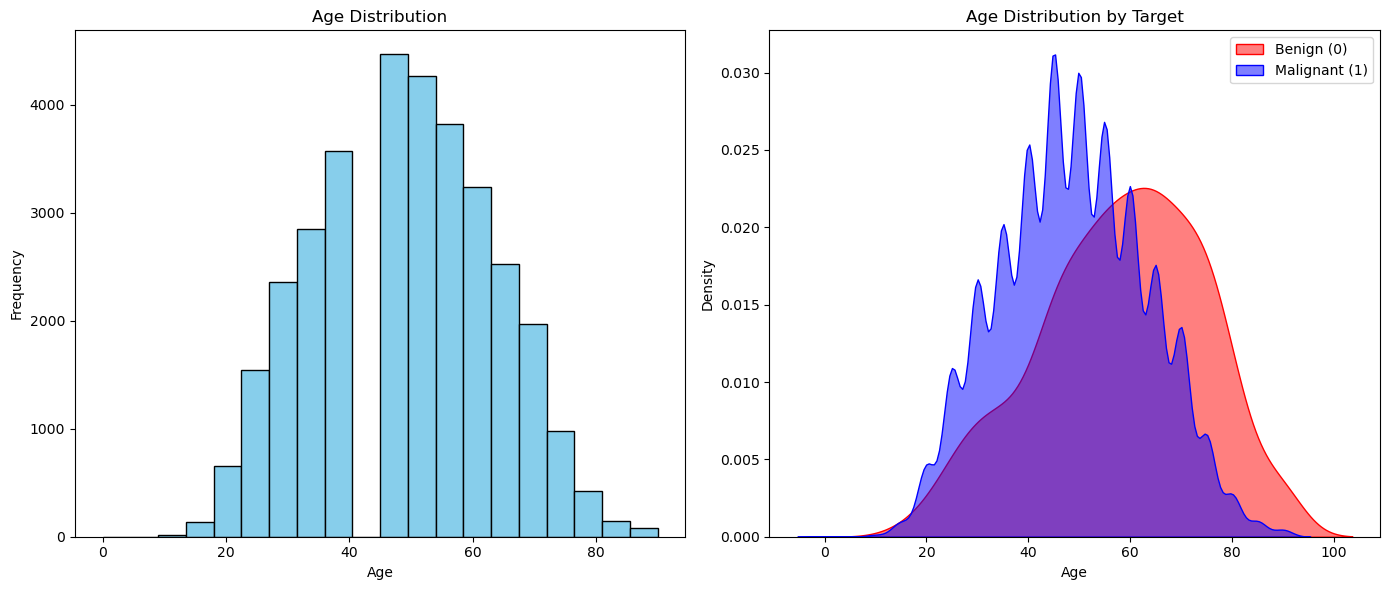

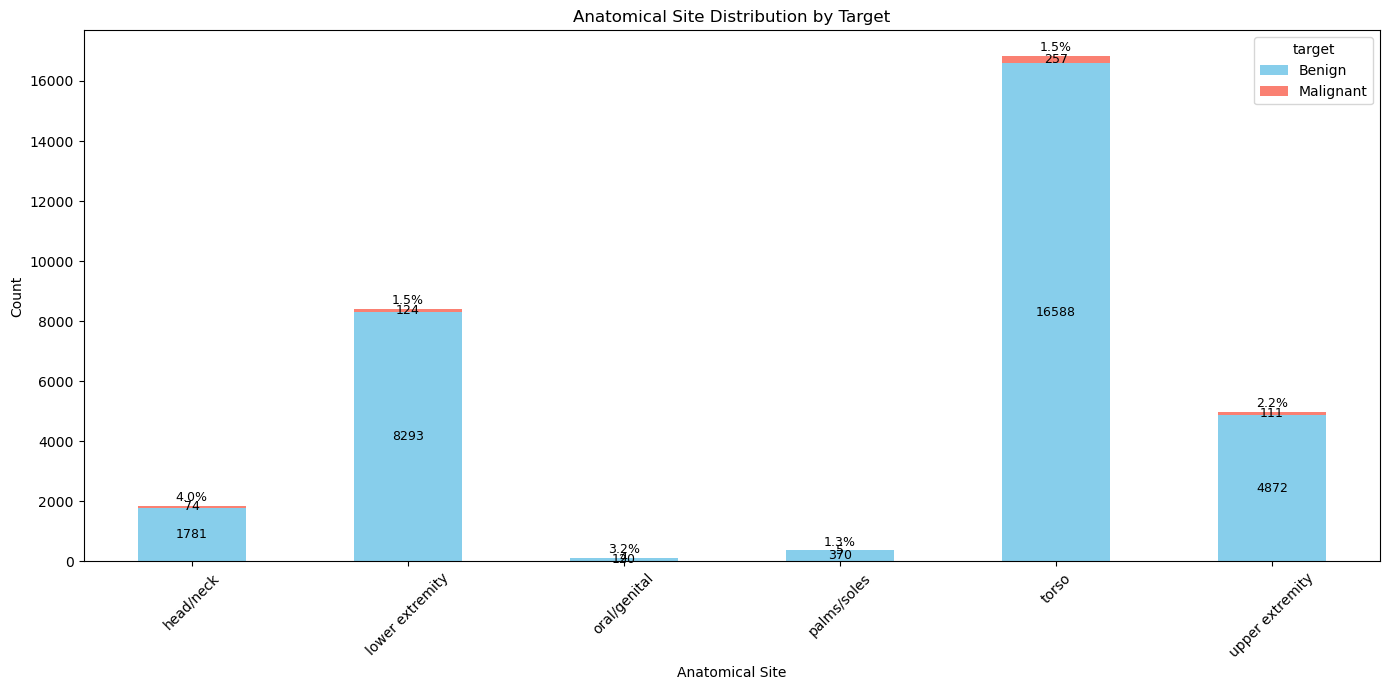

In [50]:
# Plot anatomical site distribution
site_counts = train_data['anatom_site_general_challenge'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
bars = site_counts.plot(kind='bar', ax=ax, color=plt.cm.Set3.colors)
ax.set_title('Distribution of Anatomical Sites')
ax.set_xlabel('Anatomical Site')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Annotate bars with values
for bar in bars.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', size=10, xytext=(0, 8),
                textcoords='offset points')

# Age distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
train_data['age_approx'].plot(kind='hist', bins=20, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')

# Age distribution by target
sns.kdeplot(data=train_data, x='age_approx', hue='target', 
            fill=True, common_norm=False, alpha=0.5, ax=ax2,
            palette={0: 'blue', 1: 'red'})
ax2.set_title('Age Distribution by Target')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.legend(['Benign (0)', 'Malignant (1)'])

plt.tight_layout()
plt.show()

# Create a figure for anatomical site distribution by target
fig, ax = plt.subplots(figsize=(14, 7))

# Cross-tabulation of anatomical site and target
site_target = pd.crosstab(train_data['anatom_site_general_challenge'], train_data['target'])
site_target.rename(columns={0: 'Benign', 1: 'Malignant'}, inplace=True)

# Plot stacked bar chart
site_target.plot(kind='bar', stacked=True, ax=ax, 
                 color=['skyblue', 'salmon'])
ax.set_title('Anatomical Site Distribution by Target')
ax.set_xlabel('Anatomical Site')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Add value annotations
for i, (benign, malignant) in enumerate(zip(site_target['Benign'], site_target['Malignant'])):
    total = benign + malignant
    ax.annotate(f'{benign}', 
                xy=(i, benign/2), 
                ha='center', va='center', 
                color='black',
                fontsize=9)
    ax.annotate(f'{malignant}', 
                xy=(i, benign + malignant/2), 
                ha='center', va='center', 
                color='black', 
                fontsize=9)
    # Show percentage of malignant
    if total > 0:
        percent_malignant = (malignant / total) * 100
        ax.annotate(f'{percent_malignant:.1f}%', 
                    xy=(i, total + 50), 
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()

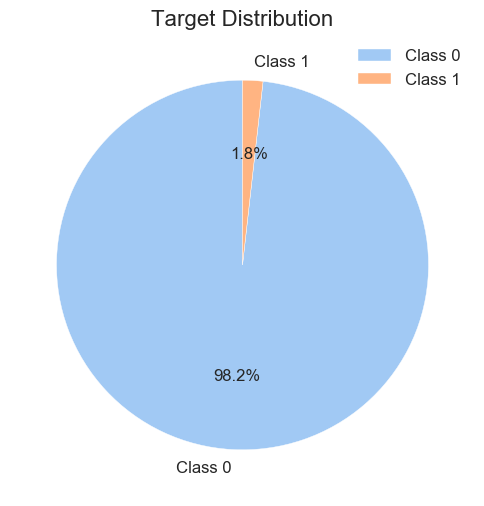

In [43]:
fig, ax = plt.subplots()
colors = sns.color_palette('pastel')[0:2]
target_dist.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6), colors=colors, labels=['Class 0', 'Class 1'])
plt.title('Target Distribution')
plt.ylabel('')
plt.legend(['Class 0', 'Class 1'], loc='upper right')
plt.show()

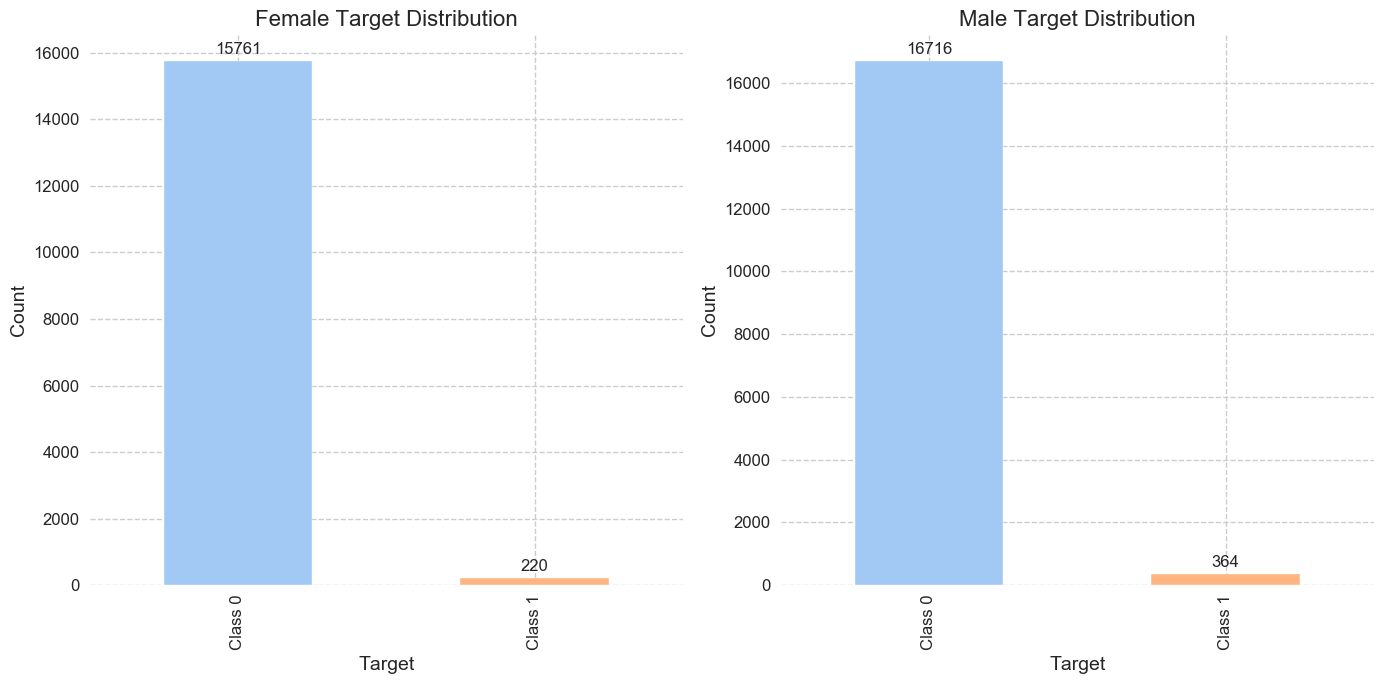

In [44]:
# Group by 'sex' and 'target' and count the occurrences
gender_target_counts = train_data.groupby(['sex', 'target']).size().unstack()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Bar chart for female
bars_female = gender_target_counts.loc['female'].plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Female Target Distribution')
ax1.set_xlabel('Target')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Class 0', 'Class 1'])

# Annotate bars with values
for bar in bars_female.patches:
    ax1.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', size=12, xytext=(0, 8),
                 textcoords='offset points')

# Bar chart for male
bars_male = gender_target_counts.loc['male'].plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Male Target Distribution')
ax2.set_xlabel('Target')
ax2.set_ylabel('Count')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Class 0', 'Class 1'])

# Annotate bars with values
for bar in bars_male.patches:
    ax2.annotate(format(bar.get_height(), '.0f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='center', size=12, xytext=(0, 8),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


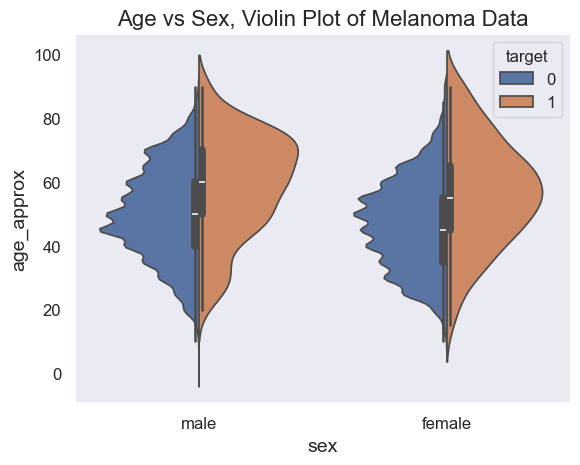

In [27]:
sns.set_theme(style="dark")

# Increase text size
plt.rc('axes', titlesize=16)  # Title size
plt.rc('axes', labelsize=14)  # X and Y label size
plt.rc('xtick', labelsize=12)  # X tick label size
plt.rc('ytick', labelsize=12)  # Y tick label size
plt.rc('legend', fontsize=12)  # Legend font size

sns.violinplot(data=train_data, x='sex', y='age_approx', hue='target',
               split=True, fill=True)
plt.title('Age vs Sex, Violin Plot of Melanoma Data')
plt.show()


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'head/neck'),
  Text(1, 0, 'upper extremity'),
  Text(2, 0, 'lower extremity'),
  Text(3, 0, 'torso'),
  Text(4, 0, 'palms/soles'),
  Text(5, 0, 'oral/genital')])

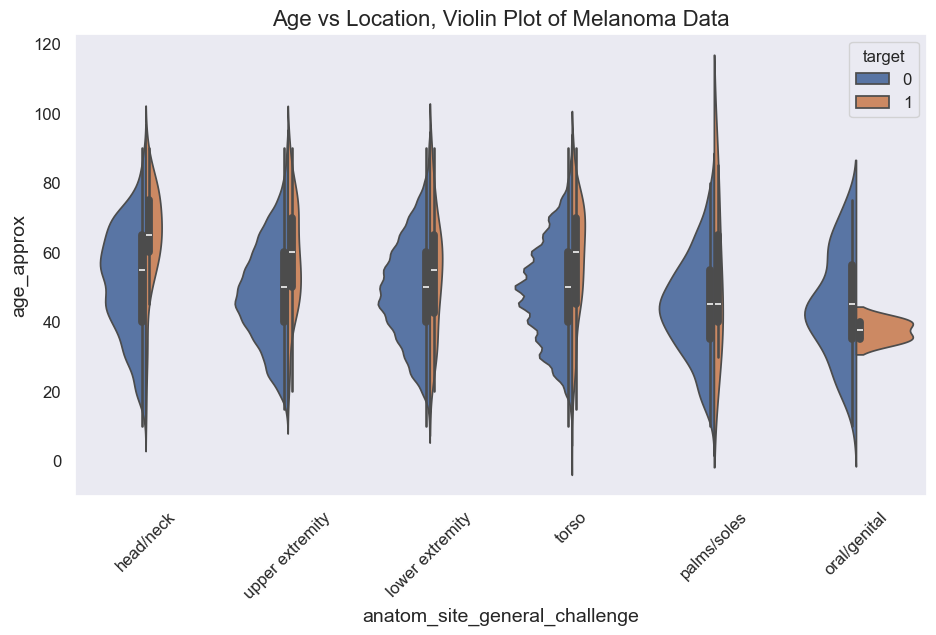

In [31]:
f, ax = plt.subplots(figsize=(11,6))

sns.violinplot(data = train_data, x='anatom_site_general_challenge', y='age_approx', hue='target',
               split=True, fill=True)
plt.title('Age vs Location, Violin Plot of Melanoma Data')
plt.xticks(rotation=45)



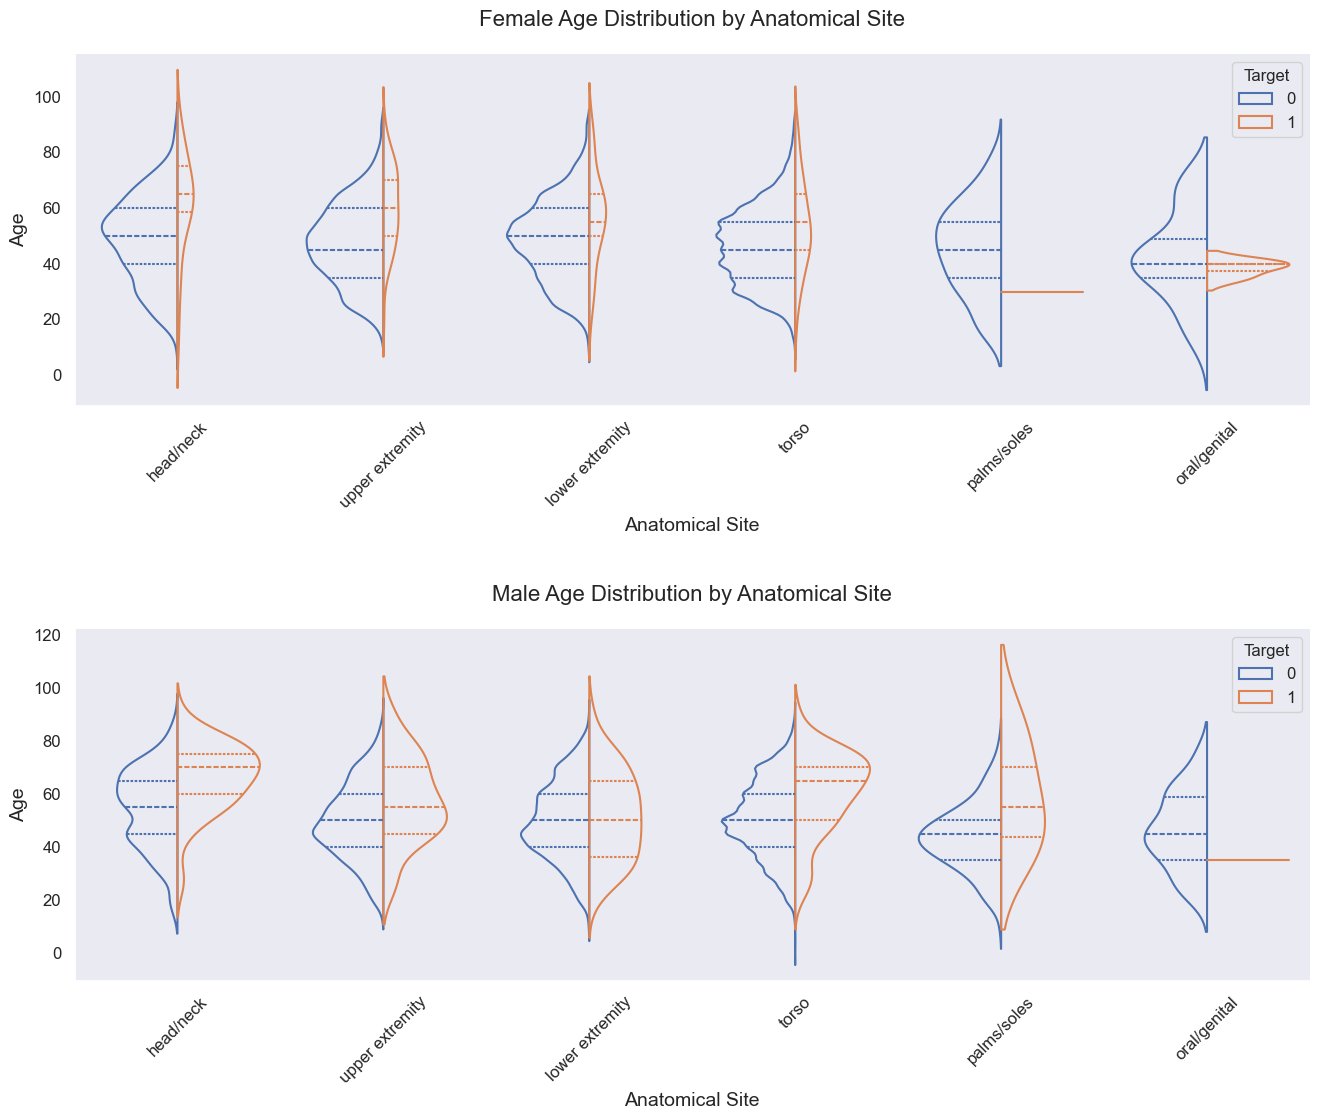

In [34]:
# Filter data for females and males
female_data = train_data[train_data['sex'] == 'female']
male_data = train_data[train_data['sex'] == 'male']

# Create a figure with two rows and one column of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Violin plot for females
sns.violinplot(data=female_data, x='anatom_site_general_challenge', y='age_approx', hue='target',
               split=True, inner='quart', fill=False, ax=ax1,
               order=['head/neck', 'upper extremity', 'lower extremity', 'torso','palms/soles', 'oral/genital'])
ax1.set_title('Female Age Distribution by Anatomical Site')
ax1.set_xlabel('Anatomical Site')
ax1.set_ylabel('Age')
ax1.legend(title='Target', loc='upper right')
ax1.tick_params(axis='x', rotation=45)
format_plot(ax1,
            title='Female Age Distribution by Anatomical Site',
            xlabel='Anatomical Site',
            ylabel='Age')

# Violin plot for males
sns.violinplot(data=male_data, x='anatom_site_general_challenge', y='age_approx', hue='target',
               split=True, inner='quart', fill=False, ax=ax2,
               order=['head/neck', 'upper extremity', 'lower extremity', 'torso', 'palms/soles', 'oral/genital'])
ax2.set_title('Male Age Distribution by Anatomical Site')
ax2.set_xlabel('Anatomical Site')
ax2.set_ylabel('Age')
ax2.legend(title='Target', loc='upper right')
ax2.tick_params(axis='x', rotation=45)
format_plot(ax2,
            title='Male Age Distribution by Anatomical Site',
            xlabel='Anatomical Site',
            ylabel='Age')

plt.tight_layout(pad=3.0)
plt.show()



In [5]:
import os
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm

import matplotlib.gridspec as gridspec



# Get the image folder path
image_folder = "data/train_images/"  # Adjust based on your actual path

# Get a sample of images (limit to 100 for performance)
sample_size = 2500
positive_train_data = train_data[train_data['target'] == 1]
shuffle_data = positive_train_data.sample(frac=1, random_state=42).reset_index(drop=True)
image_names = shuffle_data.iloc[:sample_size]['image_name'].tolist()
image_paths = [os.path.join(image_folder, name + ".jpg") for name in image_names]

# Calculate the background color for each image
print("Processing images...")
colors = []
valid_images = []

for path in tqdm(image_paths):
    if os.path.exists(path):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        color = np.mean(image, axis=(0, 1))  # Average the RGB values to get the brightness
        colors.append(color)
        valid_images.append(path)

# Convert colors to brightness and sort by brightness
colors_array = np.array(colors)
brightness = np.mean(colors_array, axis=1)
sorted_indices = np.argsort(brightness)

# Sort the images and colors by brightness
sorted_images = [valid_images[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# Convert to numpy arrays
sorted_images = np.array(sorted_images)
sorted_colors = np.array(sorted_colors)






Processing images...


100%|██████████| 572/572 [00:05<00:00, 96.38it/s] 


In [6]:
brightness = np.sort(brightness)

# Get the index of the middle image
middle_index = len(sorted_images) // 2

# Get the brightness of the middle image
middle_brightness = brightness[middle_index]
print(f"Brightness of the middle image: {middle_brightness}")

Brightness of the middle image: 145.88379414876303


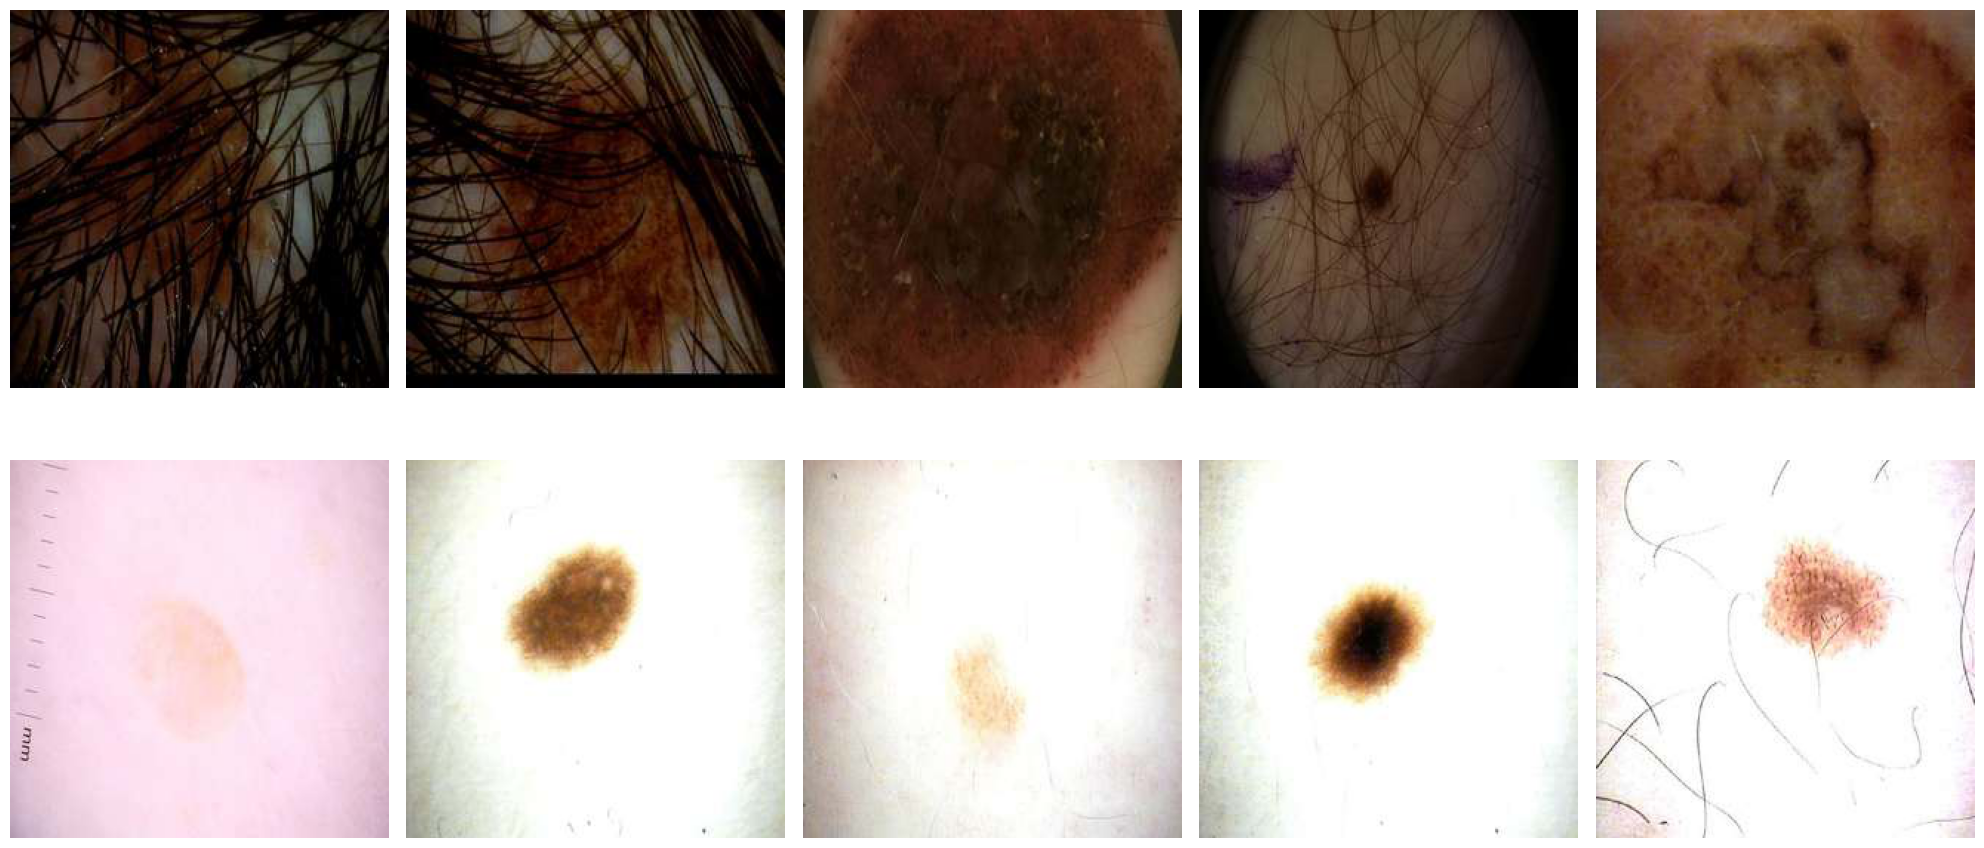

In [69]:
from PIL import Image
import matplotlib.pyplot as plt

# Select the first five darkest and lightest images
darkest_images_paths = sorted_images[:5]
lightest_images_paths = sorted_images[-5:]

# Load the images
darkest_images = [Image.open(path) for path in darkest_images_paths]
lightest_images = [Image.open(path) for path in lightest_images_paths]

# Display the images
plt.figure(figsize=(20, 10))

# Display darkest images
for i, img in enumerate(darkest_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

# Display lightest images
for i, img in enumerate(lightest_images):
    plt.subplot(2, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

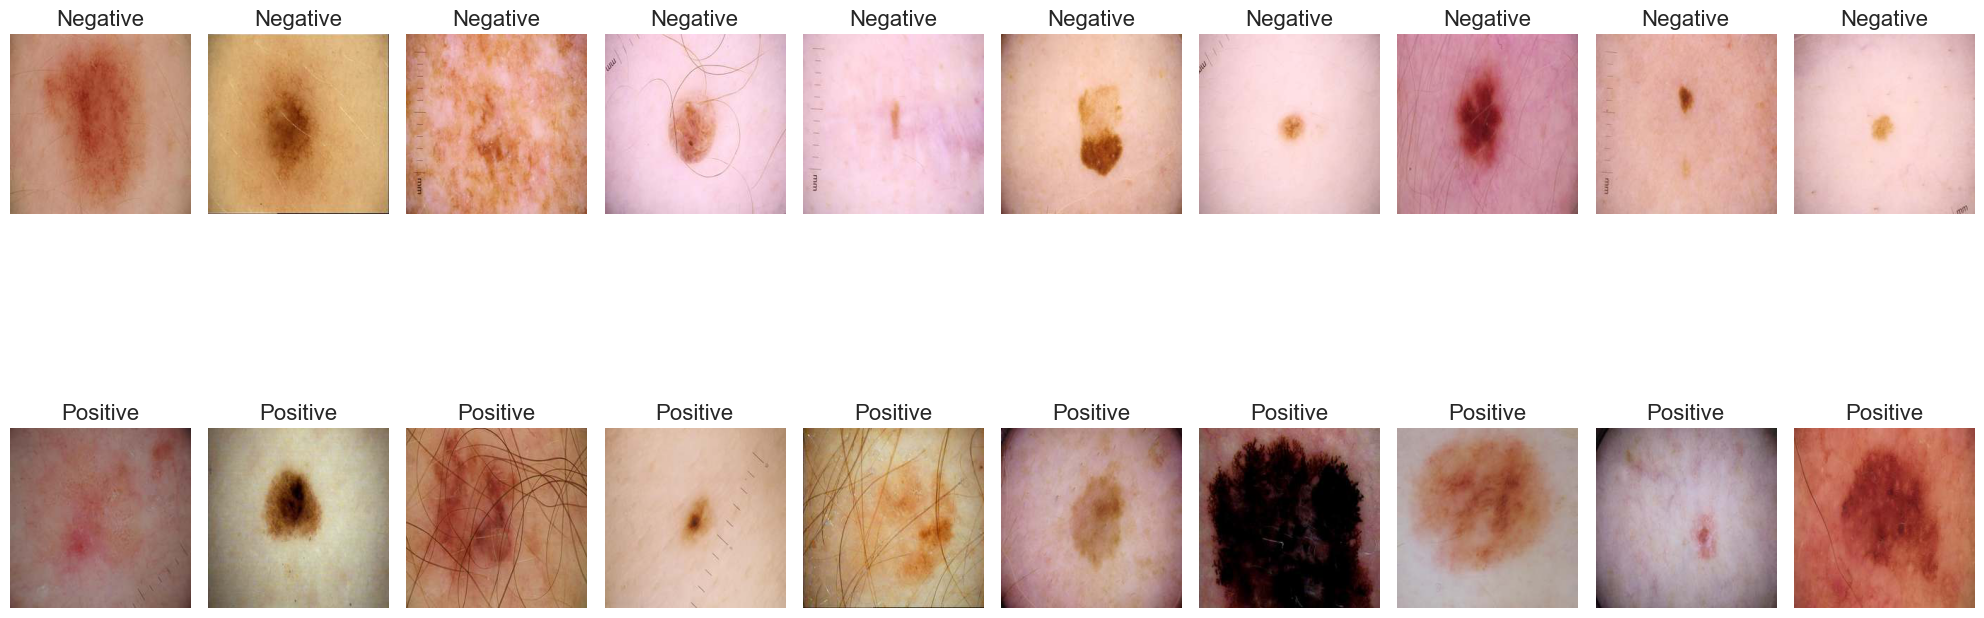

In [ ]:
import random
from PIL import Image

import matplotlib.pyplot as plt

# Filter negative and positive train data
negative_train_data = train_data[train_data['target'] == 0]
positive_train_data = train_data[train_data['target'] == 1]

# Randomly sample 10 images from each
negative_sample = negative_train_data.sample(10, random_state=42)
positive_sample = positive_train_data.sample(10, random_state=42)

# Display the images
plt.figure(figsize=(20, 10))

# Display negative samples
for i, image_name in enumerate(negative_sample['image_name']):
    image_path = os.path.join(image_folder, image_name + ".jpg")
    img = Image.open(image_path)
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.title("Negative")
    plt.axis("off")

# Display positive samples
for i, image_name in enumerate(positive_sample['image_name']):
    image_path = os.path.join(image_folder, image_name + ".jpg")
    img = Image.open(image_path)
    plt.subplot(2, 10, i + 11)
    plt.imshow(img)
    plt.title("Positive")
    plt.axis("off")

plt.tight_layout()
plt.show()

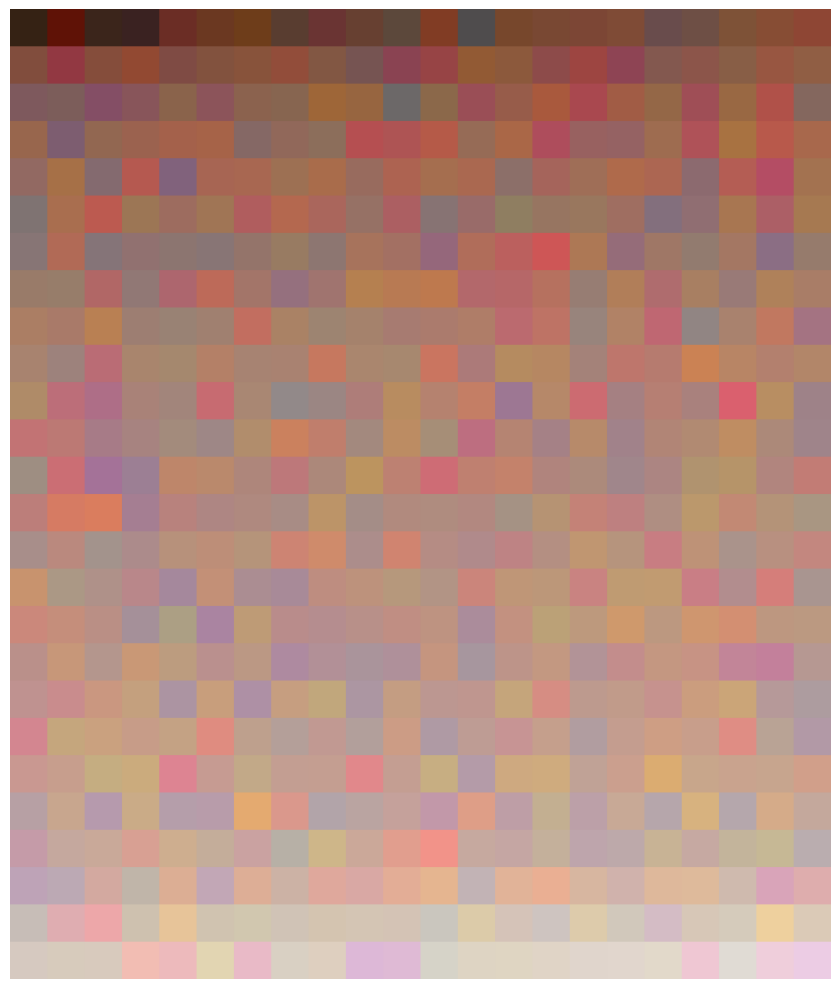

In [8]:
import numpy as np

import matplotlib.pyplot as plt

# Reshape to 10x5 grid for better visualization (50 colors total)
n_rows, n_cols = 26, 22
colors_reshaped = sorted_colors.reshape(n_rows, n_cols, 3)

# Create a figure to display the colors
plt.figure(figsize=(10, 10))

# Create an image from the colors
img = np.zeros((n_rows*50, n_cols*50, 3), dtype=np.uint8)

# Fill the image with the colors
for i in range(n_rows):
    for j in range(n_cols):
        img[i*50:(i+1)*50, j*50:(j+1)*50, :] = colors_reshaped[i, j]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_45512\1501792856.py:19: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


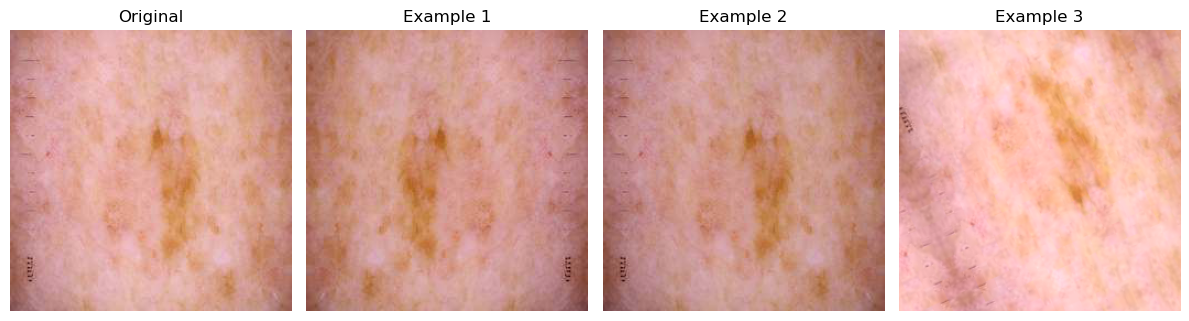

In [125]:
from synthetic_data_generate import visualize_augmentations
from PIL import Image
import albumentations as A
import numpy as np


import matplotlib.pyplot as plt

dataset_path = "./data/train_images"

# Get the path of the first image in the train dataset
first_image_path = os.path.join(dataset_path, train_data.iloc[0]['image_name'] + ".jpg")

# Open and display the image
image = Image.open(first_image_path)

 # Advanced transforms
advanced_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit=0.1)
    ], p=1.0),
    A.Resize(256, 256)
])

# Convert to numpy for albumentations
original_np = np.array(image)

    # Create figure
plt.figure(figsize=(12, 8))

# Show original
plt.subplot(1, 3+1, 1)
plt.imshow(np.array(image))
plt.title("Original")
plt.axis("off")


# Show advanced augmentations
for i in range(3):
    plt.subplot(1, 3+1, i+2)
    augmented = advanced_transform(image=original_np)
    aug_img = augmented['image']
    plt.imshow(aug_img)
    plt.title(f"Example {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()